# Secondary Mushroom Dataset Analysis

In [2]:
# import of all the necessary libraries
import urllib
import zipfile
import os

In [3]:
# Defining the function to download and extract the file, returns the path to the extracted file

def download_and_extract_file(url, destination) -> str:
    """
    Download and extract url to destination

    :param url: url to download
    :param destination: destination path

    :return: path to extracted file
    """
    urllib.request.urlretrieve(url, destination)
    with zipfile.ZipFile(destination, "r") as zip_ref:
        zip_ref.extractall("./")
    os.remove(destination)
    name = "MushroomDataset.zip"
    with zipfile.ZipFile(name, "r") as zip_ref:
        zip_ref.extractall("./")
    os.remove(name)
    res = os.listdir("./")
    for i in res:
        if i == "MushroomDataset":
            return "./MushroomDataset/"
    return "./"

In [4]:
source = "https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip"
destination_zip = "./secondary+mushroom+dataset.zip"

datasets_path = download_and_extract_file(source, destination_zip)
print("Dataset downloaded and extracted to: " + datasets_path + "\n")

Dataset downloaded and extracted to: ./MushroomDataset/



### Transforming data from csv to DataFrame

In [5]:
df = spark.read.format("csv").load(datasets_path + "secondary_data.csv", header=True, inferSchema=True, sep=";")
df.show(5)

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    p|       15.26|        x|          g|        o|                   f|              e|        NULL|         w|      16.95|     17.09|        s|           y|         w|        u|         w|       t|        g|             NULL|      d|     w|
|    p|        16.6|    

#### Visualization of the dataset

In [6]:
# We produce some statistics about the dataset
print("Number of rows: " + str(df.count()))
print("Number of columns: " + str(len(df.columns)))
print("Columns: " + str(df.columns))
print("Schema: ")
df.printSchema()

Number of rows: 61069
Number of columns: 21
Columns: ['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Schema: 
root
 |-- class: string (nullable = true)
 |-- cap-diameter: double (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- does-bruise-or-bleed: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-root: string (nullable = true)
 |-- stem-surface: string (nullable = true)
 |-- stem-color: string (nullable = true)
 |-- veil-type: string (

In [7]:
# We check if there are any null values in the dataset
from pyspark.sql.functions import count, when, isnan, col
print("Number of null values in each column: ")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


Number of null values in each column: 


+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|    0|           0|        0|      14120|        0|                   0|           9884|       25063|         0|          0|         0|    51538|       38124|         0|    57892|     53656|       0|     2471|            54715|      0|     0|
+-----+------------+----

In [8]:
# We remove duplicates from the dataset
print("Number of rows before removing duplicates: " + str(df.count()))
df = df.dropDuplicates()
print("Number of rows after removing duplicates: " + str(df.count()))

Number of rows before removing duplicates: 61069
Number of rows after removing duplicates: 60923


In [9]:
# We compute the statistics of the dataset
print("Statistics of the dataset: ")
df.describe().show()

Statistics of the dataset: 


23/12/29 09:42:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----+------------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|summary|class|      cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|      stem-height|        stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-------+-----+------------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|  count|60923|             60923|    60923|      46803|    60923|               60923|          51068|       35861|     60923|            60923|             60923|     9387|       228

In [10]:
# We delete the columns with a high number of null values, greater than 50% of the total number of rows
print("Number of rows before removing columns with a high number of null values: " + str(df.count()))

# We compute the number of null values in each column
null_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
null_values_dict = {}
for i in range(len(null_values)):
    if null_values[i] == 0:
        continue
    null_values_dict[null_values[i]] = df.columns[i]


Number of rows before removing columns with a high number of null values: 60923


In [11]:
# From the data above we decide to remove the columns with a high number of null values, greater than 50% of the total number of rows
null_values_to_remove = []
for i in null_values_dict:
    if i > df.count() / 2:
        null_values_to_remove.append(null_values_dict[i])

df = df.drop(*null_values_to_remove)
print("Number of rows after removing columns with a high number of null values: " + str(df.count()))
df.columns

Number of rows after removing columns with a high number of null values: 60923


['class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [12]:
# For all the other columns with a low number of null values, we replace the null values with the most frequent value of the column
print("Number of rows before replacing null values: " + str(df.count()))
for i in df.columns:
    if df.filter(df[i].isNull()).count() > 0:
        most_frequent_value = df.groupBy(i).count().orderBy("count", ascending=False).collect()
        if most_frequent_value[0][0] == None:
            most_frequent_value = most_frequent_value[1][0]
        else:
            most_frequent_value = most_frequent_value[0][0]
        print("Most frequent value of column " + i + ": " + str(most_frequent_value))
        df = df.fillna(most_frequent_value, subset=[i])


Number of rows before replacing null values: 60923
Most frequent value of column cap-surface: t
Most frequent value of column gill-attachment: a
Most frequent value of column gill-spacing: c
Most frequent value of column ring-type: f


In [13]:
# We compute the number of null values in each column
null_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0]
null_values_dict = {}
for i in range(len(null_values)):
    if null_values[i] == 0:
        continue
    null_values_dict[null_values[i]] = df.columns[i]
null_values_dict

{}

## Transform

In [14]:
# USe the Rformula to transform the data
from pyspark.ml.feature import RFormula
formula = RFormula(formula="class ~ .")
output = formula.fit(df).transform(df)
output.show(5)
df_transformed = output

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+----------+--------+---------+-------+------+--------------------+-----+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-color|has-ring|ring-type|habitat|season|            features|label|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+----------+--------+---------+-------+------+--------------------+-----+
|    p|       13.82|        f|          h|        o|                   f|              e|           c|         w|      16.86|     17.14|         w|       t|        p|      d|     u|(80,[0,2,10,22,28...|  0.0|
|    p|       12.16|        x|          h|        e|                   f|              e|           c|         w|      17.46|     17.51|         w|       t|        

In [15]:
# We split the dataset into training and test set
train, test = df_transformed.randomSplit([0.8, 0.2], seed=42)
print("Number of rows in the training set: " + str(train.count()))
print("Number of rows in the test set: " + str(test.count()))


Number of rows in the training set: 48842
Number of rows in the test set: 12081


Gaussian Naive Bayes


In [120]:
# We define a Gaussian Naive Bayes classifier
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(modelType="gaussian", labelCol="label", featuresCol="features")

# We train the model
model = nb.fit(train)

# We make predictions on the test set
predictions_nb = model.transform(test)


Logistic Regression

In [121]:
# We define a Logistic Regression classifier
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# We train the model
model = lr.fit(train)

# We make predictions on the test set
predictions_lr = model.transform(test)

Linear Discriminant Analysis / PCA

In [122]:
# We perform PCA on the dataset
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_transformed)
result = model.transform(df_transformed)

# We define a classifier using the PCA features
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label", featuresCol="pcaFeatures", maxIter=10)

# We split the dataset into training and test set
train_pca, test_pca = result.randomSplit([0.8, 0.2], seed=42)

# We train the model
model = lr.fit(train_pca)

# We make predictions on the test set
predictions_lrpca = model.transform(test_pca)


Random Forest Classifier

In [139]:
# We define a random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=1000)
# We train the model
model = rf.fit(train)
# We make predictions on the test set
predictions_rf = model.transform(test)


23/12/29 11:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1338.6 KiB
23/12/29 11:12:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/29 11:12:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


Definition of the evaluation function

In [135]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
# We define a function to compute the accuracy, the f1 and the f2 score of a model. We perform a binary classificatin, so we consider the class 1 as the positive class
def compute_metrics(predictions):
    """
    Compute the accuracy, the f1 and the f2 score of a model

    :param predictions: predictions of the model

    :return: accuracy, f1, f2
    """
    tp = predictions.filter(predictions.label == 1).filter(predictions.prediction == 1).count()
    tn = predictions.filter(predictions.label == 0).filter(predictions.prediction == 0).count()
    fp = predictions.filter(predictions.label == 0).filter(predictions.prediction == 1).count()
    fn = predictions.filter(predictions.label == 1).filter(predictions.prediction == 0).count()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    f2 = 5 * precision * recall / (4 * precision + recall)
    return accuracy, f1, f2
# Define a function to compute the ROC curve of a model
def compute_roc(predictions):
    """
    Compute the ROC curve of a model

    :param predictions: predictions of the model

    :return: list of tuples (false positive rate, true positive rate)
    """
    evaluator = BinaryClassificationEvaluator()
    roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    return roc

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def compute_roc_curve(predictions):
    """
    Compute the ROC curve of a model

    :param predictions: predictions of the model

    :return: list of tuples (false positive rate, true positive rate)
    """
    roc = CurveMetrics(predictions.select("probability", "label").rdd.map(lambda row: (float(row['probability'][1]), float(row['label']))))
    roc = roc.get_curve("roc")
    return roc
    

In [140]:
predictions = [predictions_nb, predictions_lr, predictions_lrpca, predictions_rf]

for i in range(len(predictions)):
    accuracy, f1, f2 = compute_metrics(predictions[i])
    roc = compute_roc(predictions[i])
    print("Accuracy of model " + str(i) + ": " + str(accuracy))
    print("F1 score of model " + str(i) + ": " + str(f1))
    print("F2 score of model " + str(i) + ": " + str(f2))
    print("AUC of the ROC curve of model " + str(i) + ": " + str(roc))
    print("\n")

Accuracy of model 0: 0.625113815081533
F1 score of model 0: 0.6933441668359401
F2 score of model 0: 0.8296872467995463
AUC of the ROC curve of model 0: 0.6911386005903638




Accuracy of model 1: 0.7753497227050741
F1 score of model 1: 0.7529133284777858
F2 score of model 1: 0.7637606206132249
AUC of the ROC curve of model 1: 0.8492113114956951




Accuracy of model 2: 0.5929972684380432
F1 score of model 2: 0.41624124421227593
F2 score of model 2: 0.3576237300583459
AUC of the ROC curve of model 2: 0.6308480618491357




23/12/29 11:13:12 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/29 11:13:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/29 11:13:18 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/29 11:13:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/29 11:13:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


Accuracy of model 3: 0.8445492922771294
F1 score of model 3: 0.8142433234421365
F2 score of model 3: 0.7856161245991754
AUC of the ROC curve of model 3: 0.9214092721631649




23/12/29 11:13:32 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/29 11:13:33 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
23/12/29 11:13:39 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


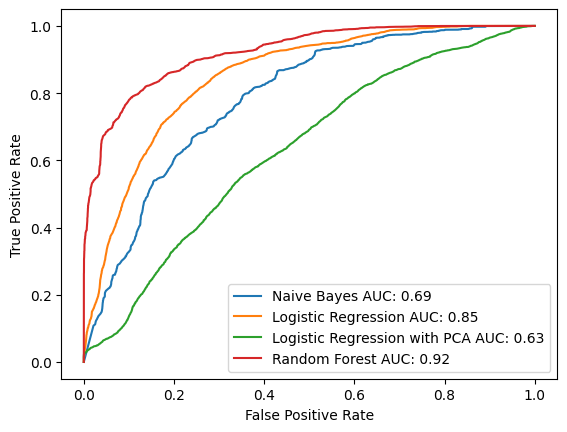

In [141]:
# We plot the ROC curve of the models
import matplotlib.pyplot as plt
roc_nb = compute_roc_curve(predictions_nb)
roc_lr = compute_roc_curve(predictions_lr)
roc_lrpca = compute_roc_curve(predictions_lrpca)
roc_rf = compute_roc_curve(predictions_rf)

plt.plot([x[0] for x in roc_nb], [x[1] for x in roc_nb], label=f"Naive Bayes AUC: {compute_roc(predictions_nb):.2f}")
plt.plot([x[0] for x in roc_lr], [x[1] for x in roc_lr], label=f"Logistic Regression AUC: {compute_roc(predictions_lr):.2f}")
plt.plot([x[0] for x in roc_lrpca], [x[1] for x in roc_lrpca], label=f"Logistic Regression with PCA AUC: {compute_roc(predictions_lrpca):.2f}")
plt.plot([x[0] for x in roc_rf], [x[1] for x in roc_rf], label=f"Random Forest AUC: {compute_roc(predictions_rf):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

Decision Tree

In [23]:
# We now fit a Decision Tree model on the training set
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(train)
predictions_dt = model.transform(test)
predictions_dt.select("prediction", "label", "probability").show(5)

+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       1.0|  1.0|           [0.0,1.0]|
|       1.0|  1.0|[0.40554539914686...|
|       1.0|  1.0|[0.40554539914686...|
|       1.0|  1.0|           [0.0,1.0]|
|       1.0|  1.0|           [0.0,1.0]|
+----------+-----+--------------------+
only showing top 5 rows



Logistic Regression

In [25]:
# We fit a logistic regression model on the training set
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=50)
pipeline = Pipeline(stages=[lr])
model = pipeline.fit(train)
predictions_lr = model.transform(test)
predictions_lr.select("prediction", "label", "probability").show(5)

+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       0.0|  1.0|[0.85557139591705...|
|       1.0|  1.0|[0.22663552246984...|
|       1.0|  1.0|[0.08872681028800...|
|       0.0|  1.0|[0.58431419924055...|
|       0.0|  1.0|[0.55383246511339...|
+----------+-----+--------------------+
only showing top 5 rows



Random Forest Classifier

In [28]:
# We fit a random forest model on the training set
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
pipeline = Pipeline(stages=[rf])
model = pipeline.fit(train)
predictions_rf = model.transform(test)
predictions_rf.select("prediction", "label", "probability").show(10)

+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       0.0|  1.0|[0.65800203642689...|
|       0.0|  1.0|[0.53184788209013...|
|       1.0|  1.0|[0.49174070911301...|
|       0.0|  1.0|[0.63078351747428...|
|       0.0|  1.0|[0.62614223117327...|
|       1.0|  1.0|[0.49174070911301...|
|       0.0|  1.0|[0.53678410842425...|
|       0.0|  1.0|[0.61187527828643...|
|       1.0|  1.0|[0.49174070911301...|
|       0.0|  1.0|[0.52983107623935...|
+----------+-----+--------------------+
only showing top 10 rows



Gradient-boosted tree classifier

In [29]:
# We fit a gradient boosted tree model on the training set
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
pipeline = Pipeline(stages=[gbt])
model = pipeline.fit(train)
predictions_gbt = model.transform(test)
predictions_gbt.select("prediction", "label", "probability").show(10)

+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       1.0|  1.0|[0.25200263958256...|
|       1.0|  1.0|[0.08603704556473...|
|       1.0|  1.0|[0.07543525103186...|
|       1.0|  1.0|[0.12255228293850...|
|       1.0|  1.0|[0.12255228293850...|
|       1.0|  1.0|[0.07543525103186...|
|       1.0|  1.0|[0.09793621884888...|
|       1.0|  1.0|[0.14696164164566...|
|       1.0|  1.0|[0.07543525103186...|
|       1.0|  1.0|[0.08603704556473...|
+----------+-----+--------------------+
only showing top 10 rows



MultiLayer Perceptron Classifier

In [36]:
# We fit a multilayer perceptron model on the training set
from pyspark.ml.classification import MultilayerPerceptronClassifier
layers = [1, 5, 5, 2]
mp = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[mp])
model = pipeline.fit(train)
predictions_mp = model.transform(test)
predictions_mp.select("prediction", "label", "probability").show(10)

23/12/23 08:03:56 ERROR Executor: Exception in task 0.0 in stage 3151.0 (TID 4778)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda$4946/0x0000000841a37040`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFa

Py4JJavaError: An error occurred while calling o2759.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3151.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3151.0 (TID 4778) (2a30bbcc1c98 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda$4946/0x0000000841a37040`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.lang.IllegalArgumentException: requirement failed: A & B Dimension mismatch!
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.ann.BreezeUtil$.dgemm(BreezeUtil.scala:42)
	at org.apache.spark.ml.ann.AffineLayerModel.eval(Layer.scala:164)
	at org.apache.spark.ml.ann.FeedForwardModel.forward(Layer.scala:508)
	at org.apache.spark.ml.ann.FeedForwardModel.predictRaw(Layer.scala:561)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:337)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:279)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:402)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:374)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4344)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3549)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at jdk.internal.reflect.GeneratedMethodAccessor230.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`ProbabilisticClassificationModel$$Lambda$4946/0x0000000841a37040`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:890)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:890)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: A & B Dimension mismatch!
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.ann.BreezeUtil$.dgemm(BreezeUtil.scala:42)
	at org.apache.spark.ml.ann.AffineLayerModel.eval(Layer.scala:164)
	at org.apache.spark.ml.ann.FeedForwardModel.forward(Layer.scala:508)
	at org.apache.spark.ml.ann.FeedForwardModel.predictRaw(Layer.scala:561)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:337)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassificationModel.predictRaw(MultilayerPerceptronClassifier.scala:279)
	at org.apache.spark.ml.classification.ProbabilisticClassificationModel.$anonfun$transform$2(ProbabilisticClassifier.scala:121)
	... 20 more


Linear support vector Machine

In [40]:
# We fit a linear support vector machine model on the training set
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=50, regParam=0.1)
pipeline = Pipeline(stages=[lsvc])
model = pipeline.fit(train)
predictions_lsvc = model.transform(test)
predictions_lsvc.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       0.0|  1.0|
+----------+-----+
only showing top 5 rows



One vs Rest

In [41]:
# We fit a one-vs-rest support vector machine model on the training set
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=50, regParam=0.1)
ovr = OneVsRest(classifier=lsvc)
pipeline = Pipeline(stages=[ovr])
model = pipeline.fit(train)
predictions_ovr = model.transform(test)
predictions_ovr.select("prediction", "label").show(5)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  1.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       0.0|  1.0|
+----------+-----+
only showing top 5 rows



Naive Bayes

In [44]:
# We fit a Naive Bayes model on the training set
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
pipeline = Pipeline(stages=[nb])
model = pipeline.fit(train)
predictions_nb = model.transform(test)
predictions_nb.select("prediction", "label", "probability").show(5)

+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       0.0|  1.0|[0.98275014681985...|
|       0.0|  1.0|[0.91435503162097...|
|       0.0|  1.0|[0.54854660799496...|
|       0.0|  1.0|[0.96004344875244...|
|       0.0|  1.0|[0.95962301924762...|
+----------+-----+--------------------+
only showing top 5 rows



Factorization machines classification

In [45]:
# We fit a factorization machines model on the training set
from pyspark.ml.classification import FMClassifier
fm = FMClassifier(labelCol="label", featuresCol="features")
pipeline = Pipeline(stages=[fm])
model = pipeline.fit(train)
predictions_fm = model.transform(test)
predictions_fm.select("prediction", "label", "probability").show(5)

+----------+-----+--------------------+
|prediction|label|         probability|
+----------+-----+--------------------+
|       1.0|  1.0|[0.08925019772191...|
|       1.0|  1.0|           [0.0,1.0]|
|       1.0|  1.0|           [0.0,1.0]|
|       1.0|  1.0|           [0.0,1.0]|
|       1.0|  1.0|           [0.0,1.0]|
+----------+-----+--------------------+
only showing top 5 rows



Evaluation of all models

In [48]:
# We evaluate the performance of the models
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
results = []
results.append(["Decision Tree", evaluator.evaluate(predictions_dt)])
results.append(["Logistic Regression", evaluator.evaluate(predictions_lr)])
results.append(["Random Forest", evaluator.evaluate(predictions_rf)])
results.append(["Gradient Boosted Tree", evaluator.evaluate(predictions_gbt)])
#results.append(["Multilayer Perceptron", evaluator.evaluate(predictions_mp)])
results.append(["Linear SVC", evaluator.evaluate(predictions_lsvc)])
results.append(["One-vs-Rest SVC", evaluator.evaluate(predictions_ovr)])
results.append(["Naive Bayes", evaluator.evaluate(predictions_nb)])
results.append(["Factorization Machines", evaluator.evaluate(predictions_fm)])


In [51]:
# Create a spark dataframe from the result

df_results = spark.createDataFrame(results, ["Model", "Area under ROC"])
df_results.show()

+--------------------+------------------+
|               Model|    Area under ROC|
+--------------------+------------------+
|Gradient Boosted ...|0.9977382138056613|
|Factorization Mac...|0.9930687935957869|
|       Random Forest|0.9171652795973095|
| Logistic Regression| 0.856038777062203|
|          Linear SVC|0.8381145253327215|
|     One-vs-Rest SVC|0.8381084882404936|
|       Decision Tree|0.6690566103828327|
|         Naive Bayes| 0.409591990269151|
+--------------------+------------------+

